# UCB Intro to Deep Learning, Week 5 Assignment - Kaggle competition on  GANs to create art

## GitHub link https://github.com/erikhel/UCB-DL-Class-Week-5

## Setup

In [ ]:
# Kaggle notes:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import pathlib
import PIL
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

# From https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

# Description of the problem

Problem: Generate Monet-style versions of (previously unseen) photos given training images of Monet paintings.

## Load data

In [ ]:
# Code adapted from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
IMG_SIZE = 256
GCS_PATH = KaggleDatasets().get_gcs_path()
train_fnames = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_fnames = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

print('{} monet tfrec, {} photo tfrec'.format(len(train_fnames),len(photo_fnames)))

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

train_ds = load_dataset(train_fnames, labeled=True).batch(1)
photo_ds = load_dataset(photo_fnames, labeled=True).batch(1)

# Exploratory data analysis (EDA)

There are 300 images of Monet paintings for training, 7,038 photos to be transformed into Monet style. Images are 256x256 RGB. See image below for example images, top row is Monet paintings and bottom row contains photos.
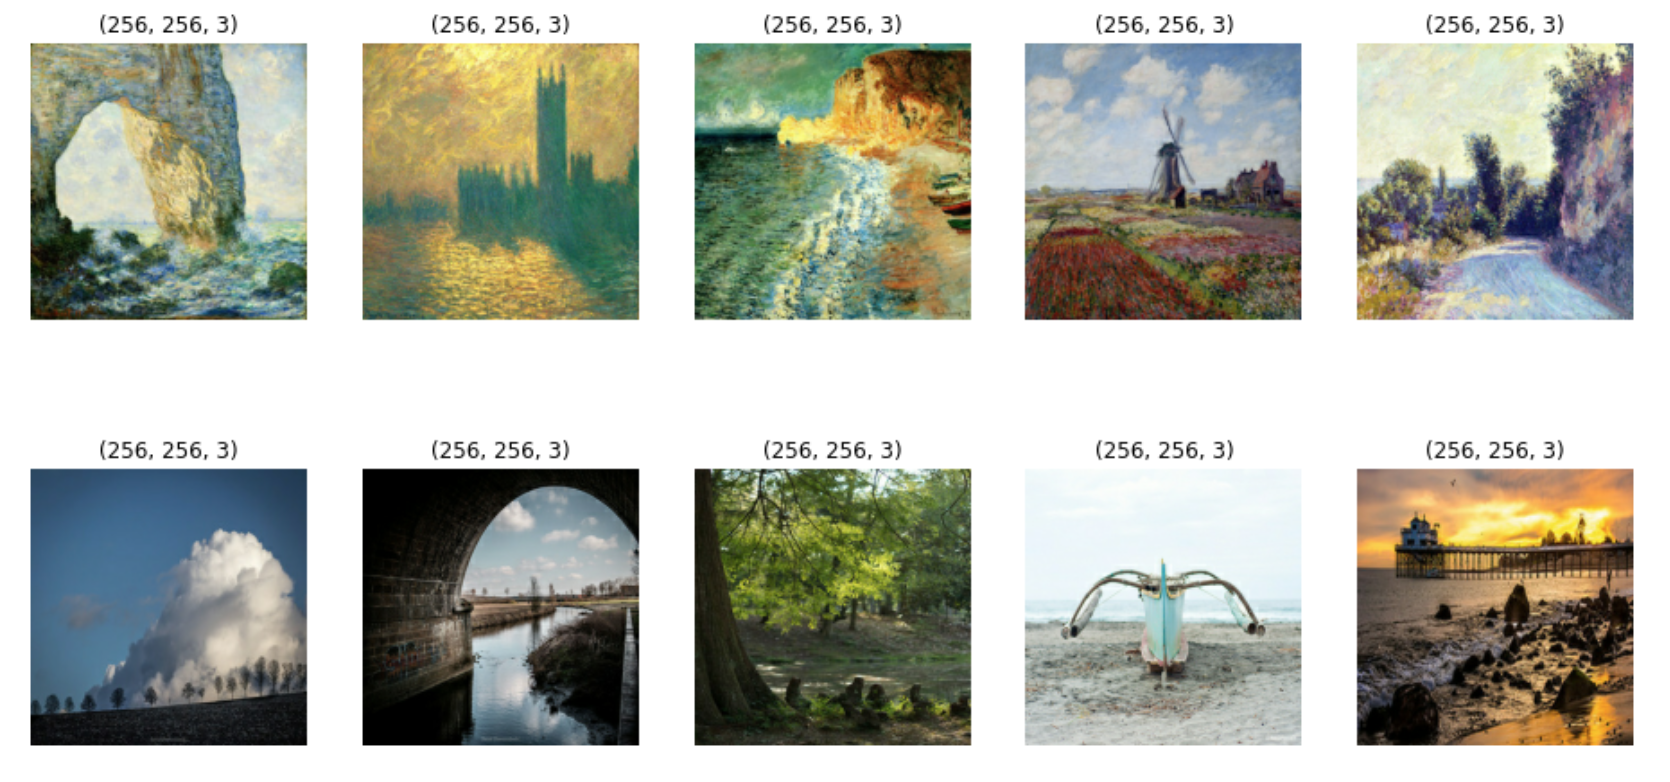

In [ ]:
print('{} training images, {} photos'.format(len(list(train_ds)), len(list(photo_ds))))

In [ ]:
plt.figure(figsize=(16, 8))
i1 = iter(train_ds)
i2 = iter(photo_ds)
for i in range(5):
    ax = plt.subplot(2,5,i+1)
    img = next(i1)[0]
    plt.imshow(img*0.5+0.5)
    ax.axis('off')
    ax.set_title(img.shape)
    ax = plt.subplot(2,5,i+1+5)
    img = next(i2)[0]
    plt.imshow(img*0.5+0.5)
    ax.axis('off')
    ax.set_title(img.shape)

# Model building and training

A CycleGAN from the paper [1] is applied here. It aims to solve the image-to-image translation problem where a mapping is sought between images without having access to paired examples in training. The implementation here is adapted from the Keras tutorial [2]. Also see Kaggle notebook at [3].

The goal of the CycleGAN is to learn $G: X\rightarrow Y$ such that the distribution of images from $G(x)$ is close to the distribution $Y$. The CycleGAN use a loss to approximately make $F(G(X)) = X$ in order to make the problem better posed. In our problem, $X$ is the photos from which we want to generate images close to Monet paintings in $Y$.

### References
[1] https://arxiv.org/pdf/1703.10593.pdf

[2] https://keras.io/examples/generative/cyclegan/

[3] https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

In [ ]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Train
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_ds, photo_ds)),
    epochs=20
    #callbacks=[plotter, model_checkpoint_callback],
)

# Result

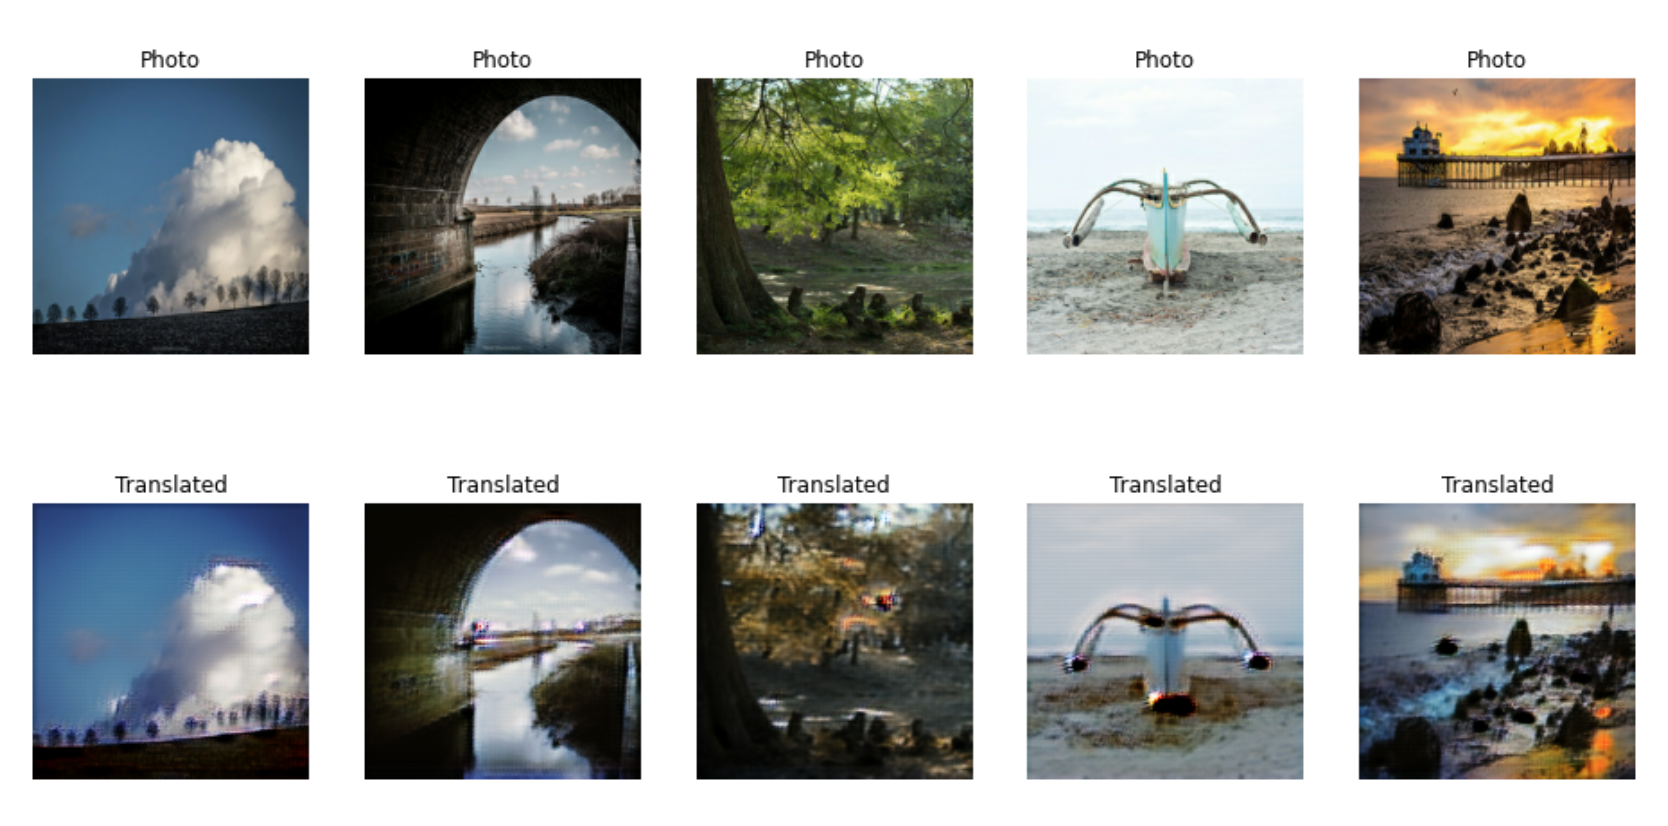

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
for i, img in enumerate(photo_ds.take(5)):
    pred = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0,i].imshow(img)
    ax[1,i].imshow(pred)
    ax[0,i].set_title('Photo')
    ax[0,i].axis('off')
    ax[1,i].set_title('Translated')
    ax[1,i].axis('off')

In [ ]:
# Export result
shutil.rmtree('/kaggle/temp/images', ignore_errors=True)
shutil.rmtree('/kaggle/temp', ignore_errors=True)
os.mkdir('/kaggle/temp')
os.mkdir('/kaggle/temp/images')

for i,img in enumerate(photo_ds):
    pred = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)

    im = PIL.Image.fromarray(pred)
    im.save(os.path.join('/kaggle/temp/images',f'img{i}.jpg'))


shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/temp/images")

# Discussion

A CycleGAN (a cycle-consistent generative adversarial networks) was implemented here for the problem of, based on images of Monet paintings, transform previously unseen photos into Monet-style paintings. It can be noted that implementing GANs requires more work and code in Keras than previous deep neural network models in the class. Indeed, the image translation problem is more complex than classification and the GAN consists of networks for both the generator and discriminator.

20 epochs of training was performed here. The notebook took about 4h to run on Kaggle (with TPU acceleration). While the transformed photos are a bit blurrier and have some hints of brush strokes, longer training and/or other model structures, hyperparameters etc should be pursued for more realistic results. The Kaggle score was 99.16509 as shown in the leaderboard below.

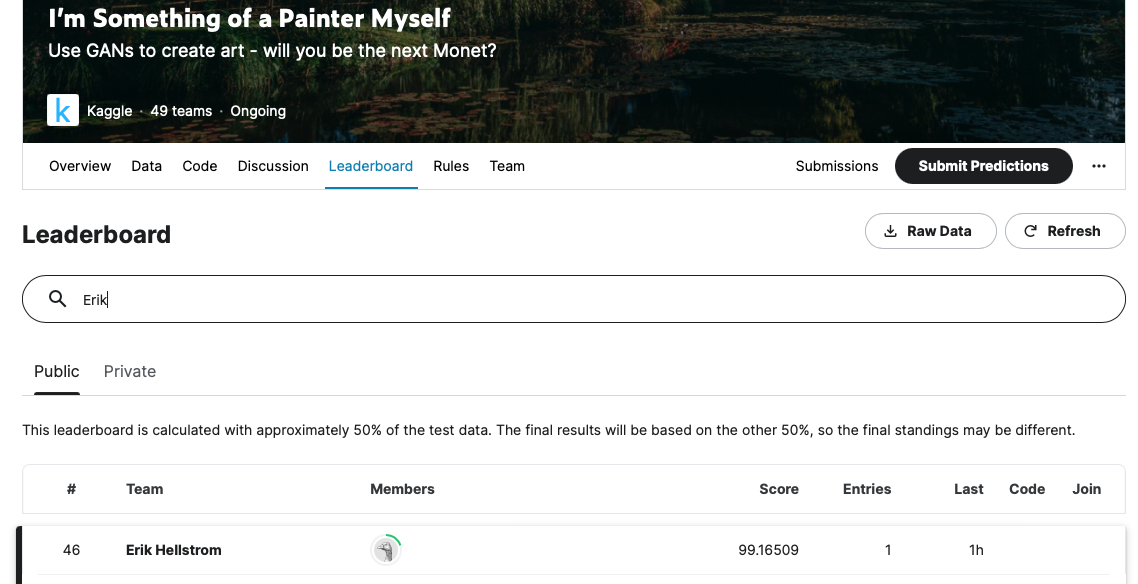